# Исследование объявлений о продаже квартир

Исследуются данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. 

Цель - научиться определять рыночную стоимость объектов недвижимости. 

Задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

### Изучение общей информации 

Импорт библиотек:

In [171]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sb
import datetime as dt

Чтение csv-файла:

In [172]:
data = pd.read_csv('/datasets/real_estate_data.csv',sep='\t')

Изучение структуры таблицы: <a id='1_info'></a>

In [173]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

В таблице 22 столбца, 23 699 строк.

In [174]:
#Изучение содержимого таблицы

display(data.head())

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


Построение гистограмм для всех стодбцов таблицы: <a id='1_hist'></a>

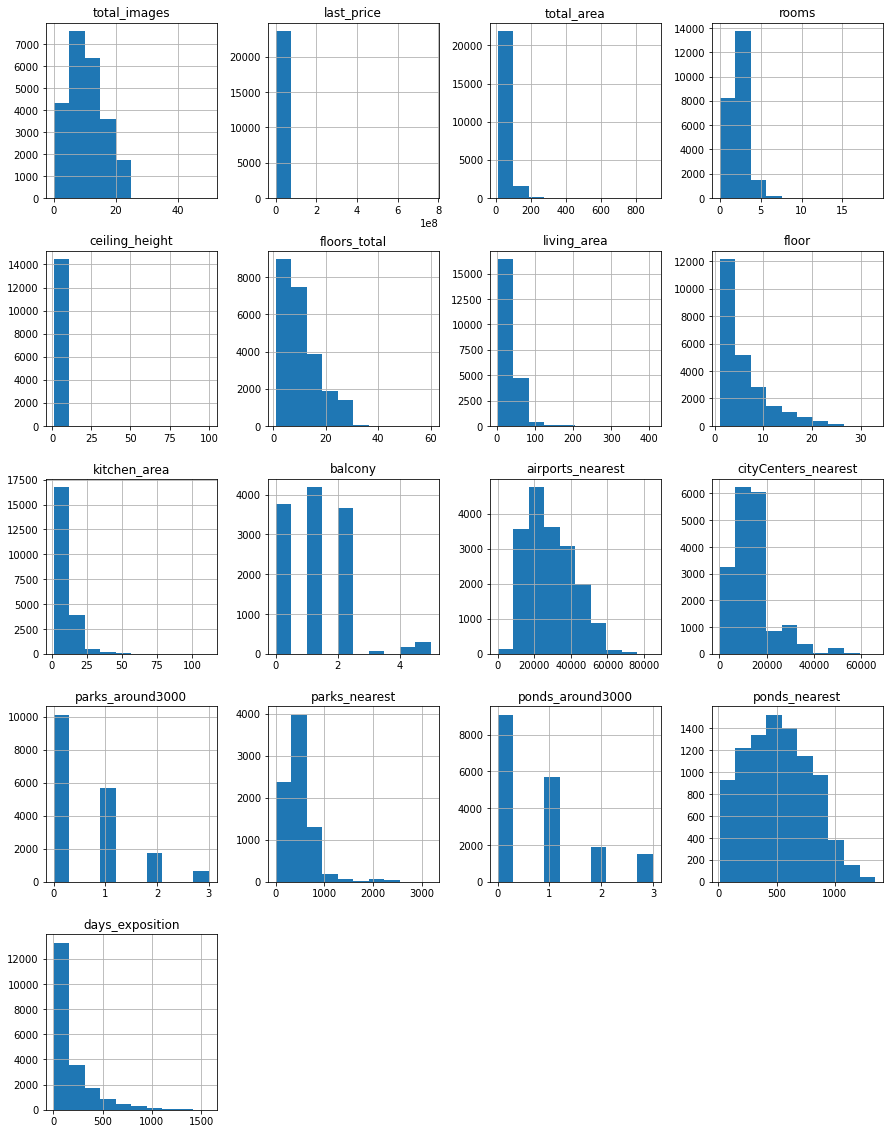

In [175]:
data.hist(figsize=(15, 20));

### Предобработка данных

#### Работа с пропусками

Вывод списка, который содержит названия столбцов с пропусками.

Методом `dropna()` удаляем из данных столбцы с пропусками, атрибутом `columns` возвращаем список оставшихся столбцов. Затем методом `drop()` удаляем из данных столбцы по этому списку, то есть те, в которых нет пропусков, и атрибутом `columns` возврящаем список оставшихся столбцов.

In [176]:
print(data.drop(columns=data.dropna(axis='columns').columns).columns)

Index(['ceiling_height', 'floors_total', 'living_area', 'is_apartment',
       'kitchen_area', 'balcony', 'locality_name', 'airports_nearest',
       'cityCenters_nearest', 'parks_around3000', 'parks_nearest',
       'ponds_around3000', 'ponds_nearest', 'days_exposition'],
      dtype='object')


##### Столбец `'ceiling_height'`
Эти данные указывает пользователь. Пропуски не связаны с какими-либо другими данными, поэтому они относятся к полностью случайным.

Высота потолков может влиять на стоимость квартиры. Поэтому при замене на медиану может нарушиться зависисмость стоимости квартиры от высоты потолков. Удалять строки с этими пропусками нецелесообразно, так как их очень много ([info](#1_info)), поэтому лучше их оставить без изменений.

##### Столбец `'floors_total'`
Данные указывает пользователь. Пропуски в этом столбце также относятся к полностью случайным.

Пропусков немного ([info](#1_info)), но это не важная характеристика, поэтому удалять эти строки нецелесообразно. Можно заменить на этаж квартиры из столбца `'floor'`, передав его в параметр метода `'fillna()'`.

In [177]:
data['floors_total'] = data['floors_total'].fillna(data['floor'])

##### Столбец `'living_area'`
Данные указывает пользователь. Вероятно, пропуски являются полностью случайными.

Пропусков немного ([info](#1_info)), это тоже не самая важная характеристика. Чтобы не исказить зависимость стоимости квартиры от этого столбца, лучше оставить пропуски без изменений.

##### Столбец `'is_apartment'`
Данные указывает пользователь. Вероятнее всего, пропуски в этом столбце являются не случайными, так как пользователь мог не указывать эту информацию из-за того, что его объект не относится к апартаментам.

Пропуски можно заменить на `False` методом `'fillna()'`.

In [178]:
data['is_apartment'] = data['is_apartment'].fillna(False)

##### Столбец `'kitchen_area'`
Данные указывает пользователь. Пропуски в этом столбце могут быть полностью случайным, либо случайными, если квартира является студией и кухни как таковой нет.

Заменять на медиану не стоит, так как площадь кухни обычно пропорциональна площади квартиры. Пропусков немного ([info](#1_info)), но это не важная характеристика, поэтому пропуски лучше оставить без изменений.

##### Столбец `'balcony'`
Данные указывает пользователь. Вероятнее всего, пропуски в этом столбце являются не случайными, так как пользователь мог не указывать эту информацию из-за того, что балкона нет.

Пропуски можно заменить на нули методом `'fillna()'`.

In [179]:
data['balcony'] = data['balcony'].fillna(0)

##### Столбец `'locality_name'`
Данные указывает пользователь. Тип пропусков может быть любой.

Данные важны для исследования, пропусков мало ([info](#1_info)), поэтому строки можно удалить методом `'dropna()'`.

In [180]:
data = data.dropna(subset=['locality_name']).reset_index(drop=True)

##### Столбец `'airports_nearest'`

Это картографические данные. Пропуски в этом столбце могут быть либо полностью случайными, либо случайными, если квартира находится слишком далеко от аэропорта.

Это не является важной характеристикой, поэтому пропуски можно оставить.

##### Столбец `'cityCenters_nearest'`

Это картографические данные. Причина пропусков неоднозначна, вероятно, пропуски являются полностью случайными.

Это важная характеристика, от которой может сильно зависеть стоимость квартиры. Поэтому заменять на медиану не стоит, так как это может исказить зависимость, лучше оставить эти пропуски.

##### Столбцы `'parks_around3000'`, `'ponds_around3000'`

Это картографические данные. 

В столбцах `'parks_around3000'` и `'ponds_around3000'` пропуски, скорее всего, являются полностью случайными, так как отсутствие парков и водоемов в объявлениях указывается. Это видно на [гистограммах](#1_hist). Это не важные для анализа характеристики, поэтому пропуски можно оставить. Ниже придется изменять тип данных в этом столбце с `float64` на `int64`, поэтому для упрощения работы с этими столбцами пропуски лучше заменить, например, на  `-1` методом `'fillna()'`. 

In [181]:
data['parks_around3000'] = data['parks_around3000'].fillna(-1)

data['ponds_around3000'] = data['ponds_around3000'].fillna(-1)

##### Столбцы `'parks_nearest'`, `'ponds_nearest'`

Это картографические данные. 

Пропуски в столбцах `'parks_nearest'`, `'ponds_nearest'`, вероятно, являются случайными, так как их гораздо больше ([info](#1_info)), чем в столбцах `'parks_around3000'` и `'ponds_around3000'`. Поэтому они могут быть связаны с отсутсвием парков и водоемов поблизости. Это не важные для анализа характеристики, поэтому пропуски можно оставить.

##### Столбец `'days_exposition'`

Это автозаполняемые данные. Пропуски говорят о том, что квартиры еще не проданы. Заменим пропуски на -1 для удобства дальнейшей  работы.

In [182]:
data['days_exposition'] = data['days_exposition'].fillna(-1)

#### Работа с типами данных

Еще раз выведем информацию о данных: <a id='2.2_info'></a>

In [183]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23650 entries, 0 to 23649
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23650 non-null  int64  
 1   last_price            23650 non-null  float64
 2   total_area            23650 non-null  float64
 3   first_day_exposition  23650 non-null  object 
 4   rooms                 23650 non-null  int64  
 5   ceiling_height        14490 non-null  float64
 6   floors_total          23650 non-null  float64
 7   living_area           21752 non-null  float64
 8   floor                 23650 non-null  int64  
 9   is_apartment          23650 non-null  bool   
 10  studio                23650 non-null  bool   
 11  open_plan             23650 non-null  bool   
 12  kitchen_area          21381 non-null  float64
 13  balcony               23650 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

Столбцы, в которых нужно изменить тип данных: 
- `'first_day_exposition'`
- `'floors_total'`
- `'balcony'`
- `'parks_around3000'`
- `'ponds_around3000'`
- `'days_exposition'`

##### Столбец `'first_day_exposition'`

В столбце указаны дата и время публикации объявления, поэтому нужно привести содержимое ячеек к типу `datetime` методом `to_datetime()`. Дата и время указаны в вормате 'год'-'месяц'-'день'T'часы':'минуты':'секунды' ([info](#2.2_info)). 

In [184]:
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'],format='%Y-%m-%dT%H:%M:%S')

Проверим корректность.

In [185]:
data['first_day_exposition'].head()

0   2019-03-07
1   2018-12-04
2   2015-08-20
3   2015-07-24
4   2018-06-19
Name: first_day_exposition, dtype: datetime64[ns]

##### Столбец `'floors_total'`

В столбце указано количество этажей в доме, это целое число. Поэтому тип данных `float64` нужно поменять на `int64`. Нужно применить метод  `astype()` и в качестве аргумента передать ему `'int'`.

In [186]:
data['floors_total']=data['floors_total'].astype('int')

##### Столбец `'balcony'`

Столбец содержит количество балконов, поэтому тип `float64` нужно поменять на `int64` методом `astype()`, передав ему в качестве аргумента `'int'`.

In [187]:
data['balcony']=data['balcony'].astype('int')

##### Столбцы `'parks_around3000'` и `'ponds_around3000'`

Столбцы содержат количество парков или водоемов, поэтому тип `float64` нужно поменять на `int64` методом `astype()`, передав ему в качестве аргумента `'int'`. Для обхода пропусков используется логическая индексация, в качестве условия передается результат работы метода `isna()` с противоположным значением.

In [188]:
data['parks_around3000'] = data['parks_around3000'].astype('int')

data['ponds_around3000'] = data['ponds_around3000'].astype('int')

##### Столбец `'days_exposition'`

Столбец содержит количество дней, поэтому тип `float64` нужно поменять на `int64` методом `astype()`, передав ему в качестве аргумента `'int'`.

In [189]:
data['days_exposition'] = data['days_exposition'].astype('int')

Для проверки выведем общую информацию о таблице:

In [190]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23650 entries, 0 to 23649
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23650 non-null  int64         
 1   last_price            23650 non-null  float64       
 2   total_area            23650 non-null  float64       
 3   first_day_exposition  23650 non-null  datetime64[ns]
 4   rooms                 23650 non-null  int64         
 5   ceiling_height        14490 non-null  float64       
 6   floors_total          23650 non-null  int64         
 7   living_area           21752 non-null  float64       
 8   floor                 23650 non-null  int64         
 9   is_apartment          23650 non-null  bool          
 10  studio                23650 non-null  bool          
 11  open_plan             23650 non-null  bool          
 12  kitchen_area          21381 non-null  float64       
 13  balcony         

#### Работа с дубликатами

Выведем список уникальных значений в столбце `'locality_name'` методом `unique()`.

In [191]:
print(data['locality_name'].unique())

['Санкт-Петербург' 'посёлок Шушары' 'городской посёлок Янино-1'
 'посёлок Парголово' 'посёлок Мурино' 'Ломоносов' 'Сертолово' 'Петергоф'
 'Пушкин' 'деревня Кудрово' 'Коммунар' 'Колпино'
 'поселок городского типа Красный Бор' 'Гатчина' 'поселок Мурино'
 'деревня Фёдоровское' 'Выборг' 'Кронштадт' 'Кировск'
 'деревня Новое Девяткино' 'посёлок Металлострой'
 'посёлок городского типа Лебяжье' 'посёлок городского типа Сиверский'
 'поселок Молодцово' 'поселок городского типа Кузьмоловский'
 'садовое товарищество Новая Ропша' 'Павловск' 'деревня Пикколово'
 'Всеволожск' 'Волхов' 'Кингисепп' 'Приозерск' 'Сестрорецк'
 'деревня Куттузи' 'посёлок Аннино' 'поселок городского типа Ефимовский'
 'посёлок Плодовое' 'деревня Заклинье' 'поселок Торковичи'
 'поселок Первомайское' 'Красное Село' 'посёлок Понтонный' 'Сясьстрой'
 'деревня Старая' 'деревня Лесколово' 'посёлок Новый Свет' 'Сланцы'
 'село Путилово' 'Ивангород' 'Мурино' 'Шлиссельбург' 'Никольское'
 'Зеленогорск' 'Сосновый Бор' 'поселок Новый Све

Дубликаты связаны с разным обозначением поселка: `'посёлок'`, `'городской посёлок'`, `'поселок'` и т.д. Чтобы от них избавиться нужен цикл, который пройдет по всем строкам `row` датафрейма. Объявим функцию `locality_name_correcting()` для обработки этих дубликатов.

Внутри цикла записано условие, которое проверяет, входит ли `'поселок'` или `'посёлок'` в содержимое столбца `'locality_name'`. Если да, то это название по словам преобразуется в список методом `split()` и записывается в переменную `old_name_list`. Новое название формируется в переменной `new_name_list`, начиная со слова `'поселок'`. Затем в цикле проверяется каждый элемент списка `old_name_list`, если элемент содержит не только строчные буквы, то он является названием и добавляется к списку  `new_name_list` методом `append()`. Регистр проверяется методом `islower()`. Новое название записывается в новый столбец `'locality_name_new'`, список преобразуется в строку методом `join()`.

Названия, не относящиеся к поселкам, записываются в новый столбец без изменений.

Функция возвращает датафрейм с новым столбцом `'locality_name_new'`.

In [192]:
def locality_name_correcting(data):

    #Для каждой строки таблицы:

    for row in range(data.shape[0]):
    
        #Проверка, есть ли в названии 'поселок' или 'посёлок'
    
        if 'поселок' in data.loc[row,'locality_name'] or 'посёлок' in data.loc[row,'locality_name']:
        
            #Преобразование строки в список слов
    
            old_name_list = data.loc[row,'locality_name'].split(' ')
        
            #Новое название начинается со слова 'поселок'
        
            new_name_list = ['поселок']
        
            #Имена собственные начинаются с букв верхнего регистра, 
            #их записываем в список new_name_list
        
            for i in range(len(old_name_list)):
            
                if not old_name_list[i].islower():
                
                    new_name_list.append(old_name_list[i])
                
            #Перевод списка в строку
                
            data.loc[row,'locality_name_new'] = ' '.join(new_name_list)
        
        else:
        
            #Если в названии нет слов 'поселок' или 'посёлок', оно остается без изменений
        
            data.loc[row,'locality_name_new'] = data.loc[row,'locality_name']
            
    return data

Применим эту функцию к датафрейму.

In [193]:
data = locality_name_correcting(data)

Для сравнения обработки дубликатов выведем количество уникальных названий до и после обработки.

In [194]:
print('Количество уникальных названий до изменений:',data['locality_name'].nunique())

print('Количество уникальных названий после изменений:',data['locality_name_new'].nunique())

Количество уникальных названий до изменений: 364
Количество уникальных названий после изменений: 318


#### Работа с аномалиями

Оценить, в каких столбцах могут быть аномалии можно по [гистограммам](#1_hist). К этим столбцам относятся:
- `'last_price'`
- `'total_area'`
- `'rooms'`
- `'ceiling_height'`
- `'living_area'`
- `'kitchen_area'`

##### Столбец `'last_price'`
В случае обнаружения аномалий в данном столбце, строки с ними придется удалить.

Изучим характерные величины методом `describe()`.

In [195]:
print(data['last_price'].describe())

count    2.365000e+04
mean     6.541127e+06
std      1.089640e+07
min      1.219000e+04
25%      3.400000e+06
50%      4.650000e+06
75%      6.799000e+06
max      7.630000e+08
Name: last_price, dtype: float64


Для начала разберемся с аномально маленькими значениями. Удалим строку с минимальным значением в 12 тысяч рублей, так как квартира не может столько  стоить.

In [196]:
data = data.drop(data['last_price'].idxmin()).reset_index(drop=True)

Квартира стоимостью 763 млн. руб сильно выбивается среди остальных значений. Построим гистограмму для квартир стоимостью больше 100 млн. руб.

<AxesSubplot:>

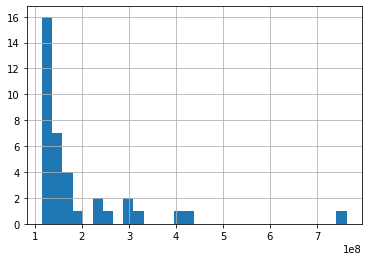

In [197]:
data.query('last_price > 100000000')['last_price'].hist(bins=30)

Выше 200 млн. руб стоят очень мало квартир, их можно удалить как выбивающиеся значения.

In [198]:
data = data.drop(data.query('last_price > 200000000').index).reset_index(drop=True)

Еще раз выведем характерные величины.

In [199]:
print(data['last_price'].describe())

count    2.364000e+04
mean     6.407745e+06
std      7.903037e+06
min      4.300000e+05
25%      3.400000e+06
50%      4.648500e+06
75%      6.790000e+06
max      1.908700e+08
Name: last_price, dtype: float64


Минимальная стоимость в 430 тыс. руб. является адекватной.

##### Столбец `'total_area'`
В случае обнаружения аномалий в этом столбце, строки также придется удалить.

Изучим характериные величины методом `describe()`.

In [200]:
print(data['total_area'].describe())

count    23640.000000
mean        60.185334
std         34.677307
min         12.000000
25%         40.000000
50%         52.000000
75%         69.700000
max        631.200000
Name: total_area, dtype: float64


Изучим гистограмму распределения квартир с площадью до 30 кв. м.

<AxesSubplot:>

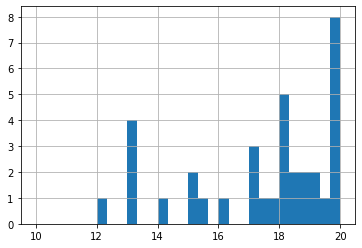

In [201]:
data['total_area'].hist(bins=30,range=(10,20))

Квартир площадью меньше 17 кв. м очень мало, их лучше удалить как выбивающиеся значения.

In [202]:
data = data.drop(data.query('total_area < 17').index).reset_index(drop=True)

Максимальное значение в 900 кв. м выглядит подозрительно. Проанализируем распределние квартир площадью более 200 кв. м на гистограмме.<a id='2.4.2'></a>

<AxesSubplot:>

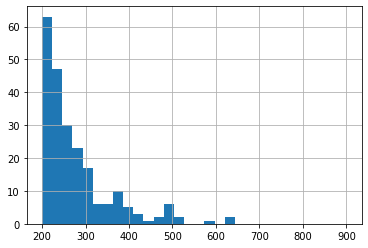

In [203]:
data['total_area'].hist(bins=30,range=(200,900))

Удалим квартиры площадью больше 550 кв. м как выбивающиеся.

In [204]:
data = data.drop(data.query('total_area > 550').index).reset_index(drop=True)

Проверим характерные величины.

In [205]:
print(data['total_area'].describe())

count    23627.000000
mean        60.134143
std         34.099808
min         17.000000
25%         40.000000
50%         52.000000
75%         69.700000
max        517.000000
Name: total_area, dtype: float64


##### Столбец `'rooms'`
Изучим характериные величины методом `describe()`.

In [206]:
print(data['rooms'].describe())

count    23627.000000
mean         2.068185
std          1.070549
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         19.000000
Name: rooms, dtype: float64


Ноль комнат может быть указано для студий. Проверим, так ли это. С помощью логической индексации выберем строки, у которых в столбце `'rooms'` стоит ноль, методом `unique()` выведем уникальные значения в столбце `'studio'` для этих строк.

In [207]:
print(data[data['rooms'] == 0]['studio'].unique())

[ True False]


Найдем, сколько квартир имеют 0 комнат и не являются студиями.

In [208]:
print(data[(data['rooms'] == 0) & (~data['studio'])]['studio'].count())

58


Эти строки лучше удалить, так как данные некорректны.

In [209]:
data = data.drop(data[(data['rooms'] == 0) & (~data['studio'])].index).reset_index(
    drop=True)

Проверим, что указано в столбце `'rooms'` для квартир-студий.

In [210]:
print(data[data['studio']]['rooms'].unique())

[0 1]


Для некоторых квартир-студий количество комнат указано как 1. Лучше заменить единицы в столбце `'rooms'` на нули для единообразия. Воспользуемся методом `where()`.

In [211]:
data['rooms'] = data['rooms'].where(~data['studio'], 0)

Проверим характериные величины.

In [212]:
print(data['rooms'].describe())

count    23569.000000
mean         2.072808
std          1.067619
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         19.000000
Name: rooms, dtype: float64


19 комнат выглядит не очень реалистично. Изучим гистограмму для квартир с количеством комнат от 5 до 19.

<AxesSubplot:>

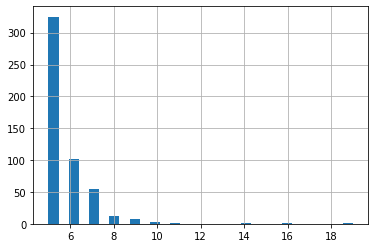

In [213]:
data['rooms'].hist(bins=30,range=(5,19))

Квартиры с количеством комнат 10 и больше лучше удалить как выбивающиеся

In [214]:
data = data.drop(data.query('rooms >= 10').index).reset_index(drop=True)

Проверим характерные величины.

In [215]:
print(data['rooms'].describe())

count    23560.000000
mean         2.068718
std          1.045461
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max          9.000000
Name: rooms, dtype: float64


##### Столбец `'ceiling_height'`
Выведем для данного столбца характериные значения методом `describe()`.

In [216]:
print(data['ceiling_height'].describe())

count    14459.000000
mean         2.768990
std          1.246574
min          1.000000
25%          2.510000
50%          2.650000
75%          2.800000
max        100.000000
Name: ceiling_height, dtype: float64


Высотой 100 м потолки точно не могут быть. В значениях больше 30 м, скорее всего, указан неправильный порядок величины. Уменьшим в 10 раз значения, которые больше 30 м. Заменим их методом `where()`.

In [217]:
data['ceiling_height'] = data['ceiling_height'].where(data['ceiling_height'] < 30,
                                                      data['ceiling_height'] / 10)

Еще раз оценим характерные значения.

In [218]:
print(data['ceiling_height'].describe())

count    14459.000000
mean         2.758782
std          0.886229
min          1.000000
25%          2.510000
50%          2.650000
75%          2.800000
max         27.500000
Name: ceiling_height, dtype: float64


По установленным нормам потолки не могут быть ниже 2,5 м, поэтому заменим все значения, которые меньше нижней границы, на `NaN` методом `where()`.

In [219]:
data['ceiling_height'] = data['ceiling_height'].where(
    data['ceiling_height'] >= 2.5, np.NaN)

Изучим гистограмму для квартир с высотой потолков больше 4 м.

<AxesSubplot:>

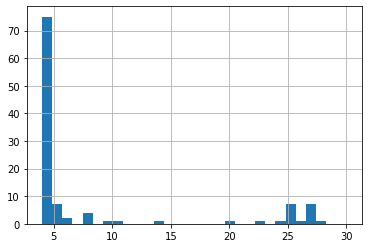

In [220]:
data['ceiling_height'].hist(bins=30,range=(4,30))

Значения 5 м и больше лучше заменить на `NaN` как выбивающиеся.

In [221]:
data['ceiling_height'] = data['ceiling_height'].where(
    data['ceiling_height'] < 5, np.NaN)

Заключительная проверка характерных значений.

In [222]:
print(data['ceiling_height'].describe())

count    14352.000000
mean         2.726190
std          0.269399
min          2.500000
25%          2.520000
50%          2.650000
75%          2.800000
max          4.900000
Name: ceiling_height, dtype: float64


##### Столбец `'floors_total'`
Выведем для данного столбца характерные значения.

In [223]:
print(data['floors_total'].describe())

count    23560.000000
mean        10.660993
std          6.584622
min          1.000000
25%          5.000000
50%          9.000000
75%         16.000000
max         60.000000
Name: floors_total, dtype: float64


Изучим гистограмму для домов выше 30 этажей.

<AxesSubplot:>

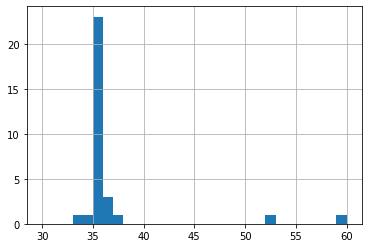

In [224]:
data['floors_total'].hist(bins=30,range=(30,60))

Значения больше 40 лучше удалить как выбивающиеся. Проверим, на каком макимальном этаже находится квартира.

In [225]:
print(data['floor'].describe())

count    23560.000000
mean         5.884720
std          4.872843
min          1.000000
25%          2.000000
50%          4.000000
75%          8.000000
max         33.000000
Name: floor, dtype: float64


Заменим значения больше 40  на `NaN` как выбивающиеся.

In [226]:
data['floors_total'] = data['floors_total'].where(
    data['floors_total'] < 40, np.NaN)

Заключительная проверка характерных значений.

In [227]:
print(data['floors_total'].describe())

count    23558.000000
mean        10.657144
std          6.571532
min          1.000000
25%          5.000000
50%          9.000000
75%         16.000000
max         37.000000
Name: floors_total, dtype: float64


##### Столбец `'living_area'`
Выведем для данного столбца характерные значения.

In [228]:
print(data['living_area'].describe())

count    21673.000000
mean        34.338284
std         21.262213
min          2.000000
25%         18.600000
50%         30.000000
75%         42.300000
max        347.500000
Name: living_area, dtype: float64


Жилая площадь не может быть 2 кв. м. Выше была найдена минимальная общая площадь квартиры, она составляет 17 кв. м. Найдем жилую площадь для этой квартиры.

In [229]:
print(data.loc[data['total_area'].idxmin(),'living_area'])

12.0


Примем это значение минимальным для жилой площади. Найдем количетсво квартир, жилая площадь которых меньше этого значения.

In [230]:
print(data[data['living_area'] < data.loc[data['total_area'].idxmin(),
                                          'living_area']]['living_area'].count())

129


Значений немного, поэтому их можно заменить на `NaN`.

In [231]:
data['living_area'] = data['living_area'].where(
    data['living_area'] >= data.loc[data['total_area'].idxmin(),'living_area'],np.NaN)

Проверим характерные значения.

In [232]:
print(data['living_area'].describe())

count    21544.000000
mean        34.483541
std         21.242038
min         12.000000
25%         18.800000
50%         30.000000
75%         42.400000
max        347.500000
Name: living_area, dtype: float64


Исследуем макимальные значения в этом столбце. Выведем пять строк с наибольшей жилой площадью. Отсортируем строки по убыванию значений в столбце `'living_area'` методом `sort_values()`, исключая незаполненные ячейки. Методом `tail()` выведем последние пять строк.

In [233]:
print(data.sort_values(by='living_area').loc[~data['living_area'].isna()]
      [['total_area','living_area']].tail())

       total_area  living_area
14016       402.0        300.0
7976        507.0        301.5
657         483.9        312.5
4215        517.0        332.0
12339       495.0        347.5


Жилая площадь адекватно соотносится с общей площадью квартиры.

##### Столбец `'kitchen_area'`
Выведем для данного столбца характерные значения.

In [234]:
print(data['kitchen_area'].describe())

count    21359.000000
mean        10.540538
std          5.784754
min          1.300000
25%          7.000000
50%          9.100000
75%         12.000000
max        107.000000
Name: kitchen_area, dtype: float64


Площадь кухни не может быть 1,3 кв. м. Согласно установленным нормам, площадь кухни должна быть не менее 5 кв. м. Найдем количество квартир, не соответствующих этим нормам.

In [235]:
print(data[data['kitchen_area'] < 5]['kitchen_area'].count())

104


Значения меньше 5 кв. м лучше заменить на `NaN`.

In [236]:
data['kitchen_area'] = data['kitchen_area'].where(data['kitchen_area'] >= 5, np.NaN)

Проанализируем максимальные значения по гистограммме для кухонь площадью больше 50 кв. м.

<AxesSubplot:>

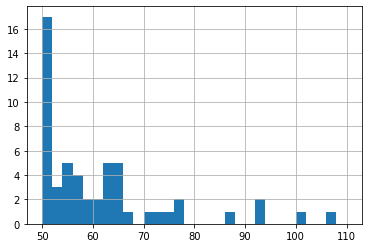

In [237]:
data['kitchen_area'].hist(bins=30,range=(50,110))

Значения больше 60 лучше заменить на `NaN`.

In [238]:
data['kitchen_area'] = data['kitchen_area'].where(data['kitchen_area'] < 60, np.NaN)

Выведем характерные значения.

In [239]:
print(data['kitchen_area'].describe())

count    21232.000000
mean        10.505076
std          5.390071
min          5.000000
25%          7.000000
50%          9.200000
75%         12.000000
max         58.400000
Name: kitchen_area, dtype: float64


##### Столбец `'balcony'`
Выведем для данного столбца характерные значения.

In [240]:
print(data['balcony'].describe())

count    23560.000000
mean         0.590492
std          0.959626
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          5.000000
Name: balcony, dtype: float64


Изучим гистограмму.

<AxesSubplot:>

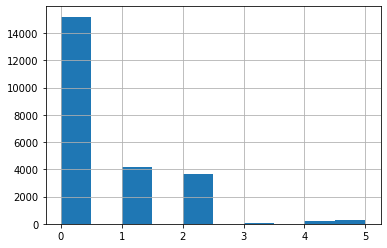

In [241]:
data['balcony'].hist(bins=10)

Значения больше 2 лучше заменить на `NaN`.

In [242]:
data['balcony'] = data['balcony'].where(data['balcony'] <= 2, np.NaN)

Проверим характерные значения.

In [243]:
print(data['balcony'].describe())

count    22994.000000
mean         0.496825
std          0.751989
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          2.000000
Name: balcony, dtype: float64


##### Столбец `'days_exposition'`
Выведем для данного столбца характерные значения, исключая пропуски.

In [244]:
print(data.query('days_exposition > -1')['days_exposition'].describe())

count    20385.000000
mean       181.033996
std        219.839624
min          1.000000
25%         45.000000
50%         96.000000
75%        232.000000
max       1580.000000
Name: days_exposition, dtype: float64


Изучим гистограмму.

<AxesSubplot:>

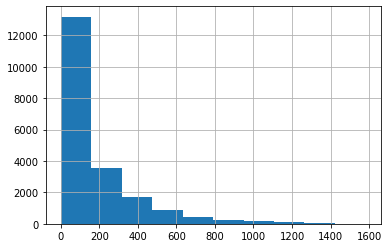

In [245]:
data.query('days_exposition > -1')['days_exposition'].hist(bins=10)

Найдем количество квартир, время продажи которых выходит за границу в сответствии с полуторным межквартильным размахом, границу запишем в переменную `days_exposition_upper_bound`.

In [246]:
days_exposition_upper_bound = (
    (data['days_exposition'].describe()['75%'] - data['days_exposition'].describe()['25%'])* 1.5 + 
      data['days_exposition'].describe()['75%']
)

print(data.query('days_exposition > @days_exposition_upper_bound')['days_exposition'].count())

2023


Заменим эти значения на -1, чтобы исключить из анализа.

In [247]:
data['days_exposition'] = data['days_exposition'].where(
    data['days_exposition'] <= days_exposition_upper_bound, -1
)

Изучим минимальные значения. Построим гистограмму для кваритр, время продажи которых меньше 5 дней.

<AxesSubplot:>

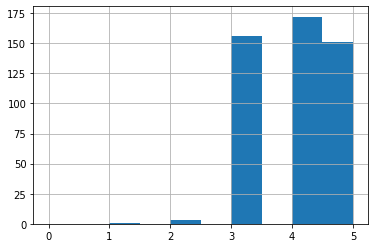

In [248]:
data.query('days_exposition > -1')['days_exposition'].hist(bins=10,range=(0,5))

Значения меньше 3 дней лучше заменить на -1 как выбивающиеся.

In [249]:
data['days_exposition'] = data['days_exposition'].where(data['days_exposition'] >= 3, -1)

Проверим характерные значения.

In [250]:
print(data.query('days_exposition > -1')['days_exposition'].describe())

count    18358.000000
mean       121.774975
std        111.698541
min          3.000000
25%         40.000000
50%         82.000000
75%        175.000000
max        462.000000
Name: days_exposition, dtype: float64


### Добавление в таблицу новых столбцов

#### Цена одного квадратного метра
Найдем стоимость одного квадратного метра как отношение стоимости квартиры к ее общей площади. Полученное значение запишем в столбец `'price_per_meter'`.

In [251]:
data['price_per_meter'] = data['last_price'] / data['total_area']

Проверим значения в столбце `'price_per_meter'` - выведем первые пять ячеек этого столбца.

In [252]:
print(data['price_per_meter'].head())

0    120370.370370
1     82920.792079
2     92785.714286
3    408176.100629
4    100000.000000
Name: price_per_meter, dtype: float64


#### День недели публикации объявления
Определим номер дня недели, в который было опубликовано объявление. Для этого воспользуемся атрибутом `dt` столбца `'first_day_exposition'`, применим к нему метод `weekday`. Значение запишем в столбец `'publication_weekday'`

In [253]:
data['publication_weekday'] = data['first_day_exposition'].dt.weekday

Проверим значения в столбце `'publication_weekday'` - выведем первые пять ячеек этого столбца.

In [254]:
print(data['publication_weekday'].head())

0    3
1    1
2    3
3    4
4    1
Name: publication_weekday, dtype: int64


#### Месяц публикации объявления
Аналогично предыдущему пункту найдем номер месяца, в который было опубликовано объявление, методом `month`. Значение запишем в столбец `'publication_month'`.

In [255]:
data['publication_month'] = data['first_day_exposition'].dt.month

Проверим значения в столбце `'publication_month'` - выведем первые пять ячеек этого столбца.

In [256]:
print(data['publication_month'].head())

0     3
1    12
2     8
3     7
4     6
Name: publication_month, dtype: int64


#### Год публикации объявления
Аналогично найдем год, в который было опубликовано объявление, методом `year`. Значение запишем в столбец `'publication_year'`.

In [257]:
data['publication_year'] = data['first_day_exposition'].dt.year

Проверим значения в столбце `'publication_year'` - выведем первые пять ячеек этого столбца.

In [258]:
print(data['publication_year'].head())

0    2019
1    2018
2    2015
3    2015
4    2018
Name: publication_year, dtype: int64


Выведем уникальные значения года публикации.<a id='3.4'></a>

In [259]:
print(data['publication_year'].unique())

[2019 2018 2015 2017 2016 2014]


#### Тип этажа квартиры
В столбец `'floor_type'` запишем один из трех типов для этажей квартир: `'первый'`, `'последний'` или `'другой'`. Для этого напишем цикл, в котором будет проверяться содержимое столбца `'floor'`. Цикл оформим в виде функции `floor_type()`, которая возвращает новый датафрейм со столбцом `'floor_type'`.

In [260]:
def floor_type(data):

    #Для каждой строки таблицы:

    for row in range(data.shape[0]):
    
        if data.loc[row,'floor'] == 1 :
        
            data.loc[row,'floor_type'] = 'первый'
    
        #Если этаж равен количеству этажей в доме:
    
        elif data.loc[row,'floor'] == data.loc[row,'floors_total'] :
        
            data.loc[row,'floor_type'] = 'последний'
        
        elif data.loc[row,'floor'] == np.NaN :
        
            data.loc[row,'floor_type'] = data.loc[row,'floor']
        
        else :
        
            data.loc[row,'floor_type'] = 'другой'
            
    return data

Применим функцию к датафрейму.

In [261]:
data = floor_type(data)

Проверим значения в столбце `'floor_type'` - выведем первые пять ячеек этого столбца.

In [262]:
print(data['floor_type'].head())

0    другой
1    первый
2    другой
3    другой
4    другой
Name: floor_type, dtype: object


#### Расстояние до центра города в километрах
В столбец `'cityCenters_nearest_km'` запишем расстояние до центра города в километрах. Для этого разделим значения в столбце `'cityCenters_nearest'` на 1000, исключая пропуски.

In [263]:
data['cityCenters_nearest_km'] = (data.loc[~data['cityCenters_nearest'].isna(),
                                           'cityCenters_nearest'] / 1000)

Пропуски заменим на `-1` и преобразуем все значения в `int`.

In [264]:
data['cityCenters_nearest_km'] = data['cityCenters_nearest_km'].fillna(-1).astype('int')

Проверим значения в столбце `'cityCenters_nearest_km'` - выведем первые пять ячеек этого столбца.

In [265]:
print(data['cityCenters_nearest_km'].head())

0    16
1    18
2    13
3     6
4     8
Name: cityCenters_nearest_km, dtype: int64


### Исследовательский анализ данных

#### Изучение основных параметров

##### Общая площадь
Для начала изучим общую характеристику данных в столбце `'total_area'`.

In [266]:
print(data['total_area'].describe())

count    23560.000000
mean        60.121654
std         33.783152
min         17.000000
25%         40.000000
50%         52.000000
75%         69.700000
max        517.000000
Name: total_area, dtype: float64


Медианное значение составляет 52 кв. м, среднее - 60 кв. м. Площадь квартир имеет большой разброс по величине. Об этом говорит большое значение стандартного отклонения, равного 34 кв. м. В целом это нормально для такого широкого диапазона значений (от 17 кв. м до 517 кв. м) относительно самих значений, где минимальное и максимальное значения отличаются почти на 2 порядка. <a id='4.1.1'></a>

Изучим гистограмму распределения площадей квартир.

<AxesSubplot:>

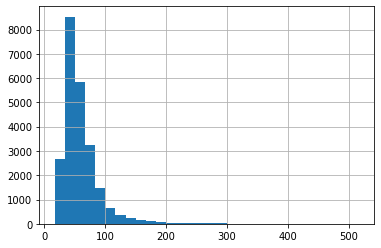

In [267]:
data['total_area'].hist(bins=30)

Гистограмма соответствует распределению Пуассона, но с очень длинным хвостом. Пик на гистограмме только один, он соответствует медианному значению.

Построим гистограмму для диапазона площадей от 200 кв. м до 517 кв. м, для этого передадим функции аргумент `range=(200,517)`.

<AxesSubplot:>

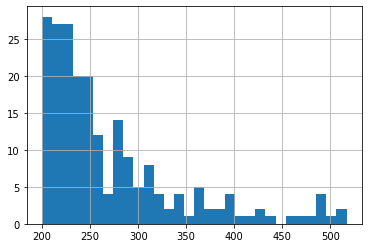

In [268]:
data['total_area'].hist(bins=30,range=(200,517))

Квартир с большой площадью гораздо меньше других, однако их распределение соответствует хвосту пуассоновского распределения.

##### Жилая площадь

Изучим характерные величины методом `describe()`.

In [269]:
print(data['living_area'].describe())

count    21544.000000
mean        34.483541
std         21.242038
min         12.000000
25%         18.800000
50%         30.000000
75%         42.400000
max        347.500000
Name: living_area, dtype: float64


Медианное значение составляет 30 кв. м, среднее - 34,5 кв. м, стандартное отклонение - 21 кв. м, диапазон величин - от 12 кв. м до 347,5 кв. м. Ситуация аналогична распределению [общей площади квартир](#4.1.1). 

Изучим гистограмму для жилых площадей квартир.

<AxesSubplot:>

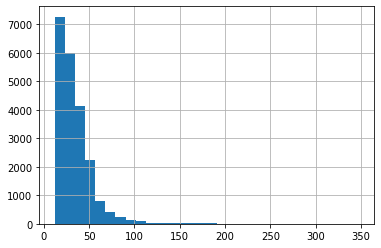

In [270]:
data['living_area'].hist(bins=30)

Распределение также соответствует распределению Пуассона.

##### Площадь кухни

Изучим характерные величины методом `describe()`.

In [271]:
print(data['kitchen_area'].describe())

count    21232.000000
mean        10.505076
std          5.390071
min          5.000000
25%          7.000000
50%          9.200000
75%         12.000000
max         58.400000
Name: kitchen_area, dtype: float64


Медианное значение составляет 9,2 кв. м, среднее - 10,5 кв. м, стандартное отклонение - 5,4 кв. м, диапазон величин - от 5 кв. м до 58,4 кв. м. Ситуация также аналогична распределению [общей площади квартир](#4.1.1). 

Изучим гистограмму для площадей кухонь.

<AxesSubplot:>

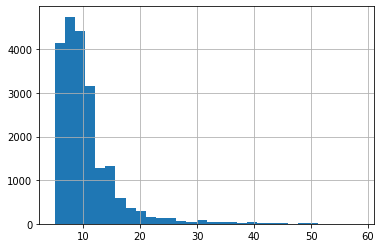

In [272]:
data['kitchen_area'].hist(bins=30)

Распределение также соответствует распределению Пуассона.

##### Цена объекта

Изучим характерные величины методом `describe()`.

In [273]:
print(data['last_price'].describe())

count    2.356000e+04
mean     6.393961e+06
std      7.785074e+06
min      4.300000e+05
25%      3.438150e+06
50%      4.650000e+06
75%      6.799000e+06
max      1.908700e+08
Name: last_price, dtype: float64


Медианное значение составляет 4,65 млн. руб, среднее - 6,39 млн. руб, стандартное отклонение - 7,8 млн. руб, диапазон величин - от 0,43 млн. руб до 191 млн. руб. Минимальное и максимальное значения отличаются почти на 3 порядка. Ситуация аналогична распределению [общей площади квартир](#4.1.1). 

Изучим гистограмму для стоимости квартир.

<AxesSubplot:>

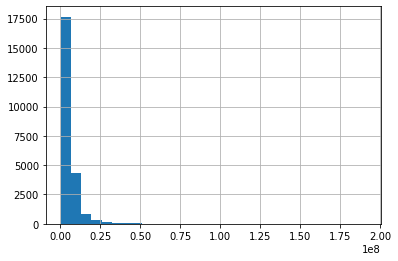

In [274]:
data['last_price'].hist(bins=30)

Чтобы детальнее рассмотреть распределения, построим гистограммы для двух участков: от 0 до 100 млн и от 100 до 200 млн. руб. Графики разделим функцией `show()`.

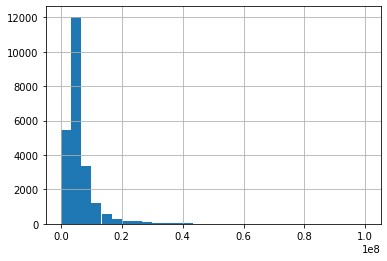

<AxesSubplot:>

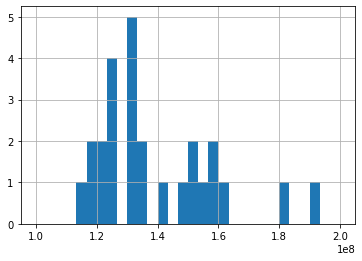

In [275]:
data['last_price'].hist(bins=30,range=(0,100000000))

plt.show()

data['last_price'].hist(bins=30,range=(100000000,200000000))

Распределение также соответствует распределению Пуассона с длинным хвостом.

##### Количество комнат

Изучим характерные величины методом `describe()`.

In [276]:
print(data['rooms'].describe())

count    23560.000000
mean         2.068718
std          1.045461
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max          9.000000
Name: rooms, dtype: float64


Медианное и среднее количество комнат близки по величине - 2 комнаты, стандартное отклонение - 1, диапазон величин - от 0 (студии) до 9. Ситуация аналогична распределению [общей площади квартир](#4.1.1). 

Изучим гистограмму для количества комнат.

<AxesSubplot:>

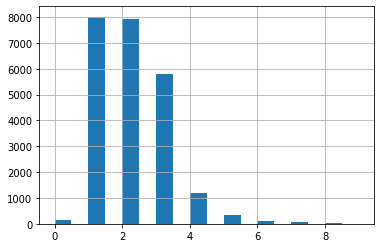

In [277]:
data['rooms'].hist(bins=18)

Распределение также соответствует распределению Пуассона.

##### Высота потолков

Изучим характерные величины методом `describe()`.

In [278]:
print(data['ceiling_height'].describe())

count    14352.000000
mean         2.726190
std          0.269399
min          2.500000
25%          2.520000
50%          2.650000
75%          2.800000
max          4.900000
Name: ceiling_height, dtype: float64


Медианное значение составляет 2,65 м, среднее - 2,73 м, стандартное отклонение - 0,27 м, диапазон величин - от 2,5 м до 4,9 м. Стандартное отклонение относительно не велико, разброс величин небольшой.

Изучим гистограмму для высоты потолков.

<AxesSubplot:>

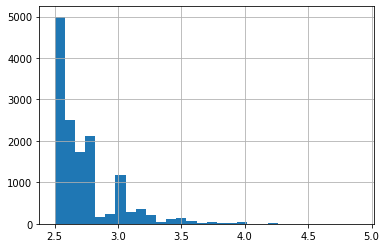

In [279]:
data['ceiling_height'].hist(bins=30)

Распределение соответствует распределению Пуассона с пиком в области медианного значения.

##### Этаж квартиры

Изучим характерные величины методом `describe()`.

In [280]:
print(data['floor'].describe())

count    23560.000000
mean         5.884720
std          4.872843
min          1.000000
25%          2.000000
50%          4.000000
75%          8.000000
max         33.000000
Name: floor, dtype: float64


Медианное значение - 4 этаж, среднее - 6, стандартное отклонение - 5, диапазон величин - от 1 до 33. Минимальное и максимальное значения отличаются более, чем на порядок. Здесь стандартное отклонение немного превышает медианное значение. 

Изучим гистограмму для этажей квартир.

<AxesSubplot:>

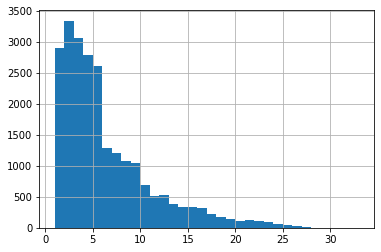

In [281]:
data['floor'].hist(bins=32)

Наиболее часто встречающийся этаж - 2. Распределение соответствует распределению Пуассона.

##### Тип этажа квартиры

Изучим характерные величины методом `describe()`.

In [282]:
print(data['floor_type'].describe())

count      23560
unique         3
top       другой
freq       17262
Name: floor_type, dtype: object


Наиболее часто встречающийся тип этажа - `'другой'`, из 23 560 объявлений сюда относится 17 262. 

Изучим гистограмму для типов этажей квартир.

<AxesSubplot:>

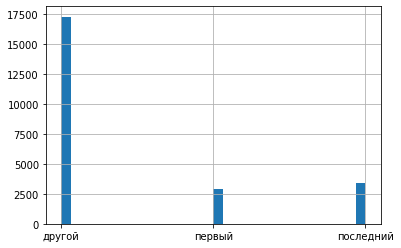

In [283]:
data['floor_type'].hist(bins=32)

Последний этаж встречается немного чаще первого.

##### Общее количество этажей в доме

Изучим характерные величины методом `describe()`.

In [284]:
print(data['floors_total'].describe())

count    23558.000000
mean        10.657144
std          6.571532
min          1.000000
25%          5.000000
50%          9.000000
75%         16.000000
max         37.000000
Name: floors_total, dtype: float64


Медианное значение - 9 этаж, среднее - 11, стандартное отклонение - 7, диапазон величин - от 1 до 37. 

Изучим гистограмму для количетсва этажей.

<AxesSubplot:>

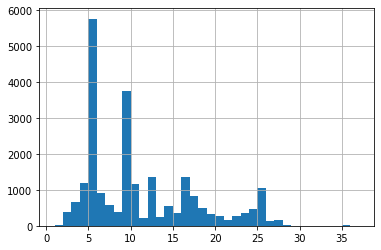

In [285]:
data['floors_total'].hist(bins=36)

Распределение не соответствует пуассоновскому. На графике есть два наибольших пика, которые соответствуют 5 и 9 этажам. Такое неоднородное распределение может быть связано с особенносями типовых домов в Санкт-Петербурге.

##### Расстояние до центра города в метрах

В столбце `'cityCenters_nearest_km'` пропуски были заменены на `-1`. Изучим характерные величины методом `describe()`, исключая пропуски.

In [286]:
print(data.query('cityCenters_nearest_km != -1')['cityCenters_nearest_km'].describe())

count    18078.000000
mean        13.716838
std          8.613037
min          0.000000
25%          9.000000
50%         13.000000
75%         16.000000
max         65.000000
Name: cityCenters_nearest_km, dtype: float64


Медианное значение составляет 13  км, среднее - 14 км, стандартное отклонение - 8,6 км, диапазон величин - от 0 до 65 км. Стандартное отклонение немного меньше медианного значения. 

Изучим гистограмму для расстояния до центра города.

<AxesSubplot:>

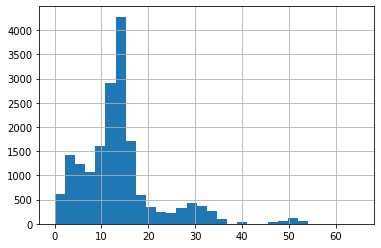

In [287]:
data.query('cityCenters_nearest_km != -1')['cityCenters_nearest_km'].hist(bins=30,range=(0,65))

Распределение не соответствует пуассоновскому. Это может быть связано с тем, что в таблице присутствует несколько населенных пунктов. Добавим на общую гистограмму два распределения: для Санкт-Петербурга и остальных населенных пунктов.

<AxesSubplot:ylabel='Frequency'>

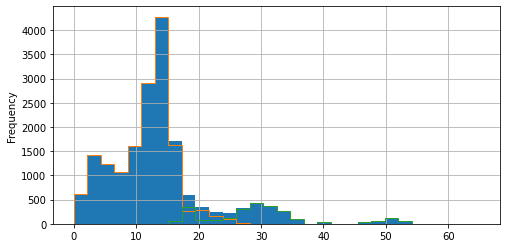

In [288]:
ax = data.query('cityCenters_nearest_km != -1')['cityCenters_nearest_km'].plot(
    kind='hist',bins=30,figsize=(8,4))

data.query('cityCenters_nearest_km != -1 and locality_name == "Санкт-Петербург"')[
    'cityCenters_nearest_km'].plot(kind='hist',bins=30,ax=ax,histtype='step',range=(0,65))

data.query('cityCenters_nearest_km != -1 and locality_name != "Санкт-Петербург"')[
    'cityCenters_nearest_km'].plot(kind='hist',bins=30,ax=ax,histtype='step',grid=True,range=(0,65))

Так и есть, на общей гистограмме пики в районе 5 км и 15 км обеспечиваются квартирами в Санкт-Петербурге, а небольшие пики в области 30, 40 и 50 км обусловлены другими населенными пунктами.

##### Расстояние до ближайшего аэропорта

Изучим характерные величины методом `describe()`.

In [289]:
print(data['airports_nearest'].describe())

count    18055.000000
mean     28815.336472
std      12641.130159
min          0.000000
25%      18575.500000
50%      26766.000000
75%      37311.500000
max      84869.000000
Name: airports_nearest, dtype: float64


Медианное значение составляет 27 км, среднее - 29 км, стандартное отклонение - 12,6 км, диапазон величин - от 0 до 85 км.

Изучим гистограмму для расстояния до ближайшего аэропорта.

<AxesSubplot:>

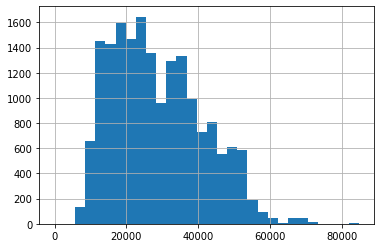

In [290]:
data['airports_nearest'].hist(bins=30)

В целом, тенденция распределения соответствует пуассоновскому. Побочные пики также могут быть связаны с наличием населенных пунктов.

##### Расстояние до ближайшего парка

Изучим характерные величины методом `describe()`.

In [291]:
print(data['parks_nearest'].describe())

count    8038.000000
mean      490.547400
std       342.867248
min         1.000000
25%       287.000000
50%       453.500000
75%       612.000000
max      3190.000000
Name: parks_nearest, dtype: float64


Медианное значение составляет 454 м, среднее - 491 м, стандартное отклонение - 343 м, диапазон величин - от 1 до 3190 м.

Изучим гистограмму для расстояния до ближайшего парка.

<AxesSubplot:>

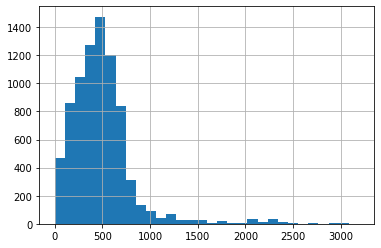

In [292]:
data['parks_nearest'].hist(bins=30)

Распределение соответствует пуассоновскому, максимум находится в области медианного и среднего значений.

##### День и месяц публикации объявления

Изучим характерные величины для столбца с днем недели публикации объявления методом `describe()`.

In [293]:
print(data['publication_weekday'].describe())

count    23560.000000
mean         2.567572
std          1.788779
min          0.000000
25%          1.000000
50%          3.000000
75%          4.000000
max          6.000000
Name: publication_weekday, dtype: float64


Медианное значение - четверг, среднее - четверг, стандартное отклонение - 2 дня.

Изучим гистограмму для дня публикации объявления.

<AxesSubplot:>

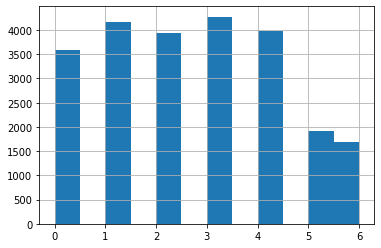

In [294]:
data['publication_weekday'].hist(bins=12)

В будни объявления о продаже квартир публикуют чаще, чем на выходных, причем ближе к выходным частота возрастает. Чаще всего объявления публикуют по четвергам.

Изучим характерные величины для столбца с месяцем публикации объявления методом `describe()`.

In [295]:
data['publication_month'].describe()

count    23560.000000
mean         6.397029
std          3.490080
min          1.000000
25%          3.000000
50%          6.000000
75%         10.000000
max         12.000000
Name: publication_month, dtype: float64

Медианное значение - июнь, среднее - июнь, стандартное отклонение - 3,5 месяца.

Изучим гистограмму для месяца публикации объявления.

<AxesSubplot:>

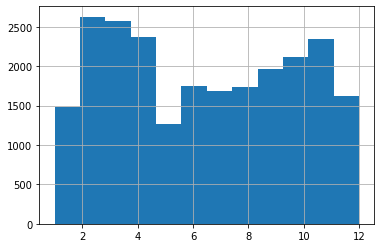

In [296]:
data['publication_month'].hist(bins=12)

Реже всего объявления публикуют в декабре, январе и мае. Это может быть связано с выходными и праздничными днями. Чаще всего объявления публикуют в феврале, марте и апреле, за этот период частота немного падает. А в период с июля по ноябрь количество объевлений возрастает.

#### Изучение скорости продажи квартир

Построим гистограмму распределения для столбца `'days_exposition'`, исключая аномалии.

<AxesSubplot:>

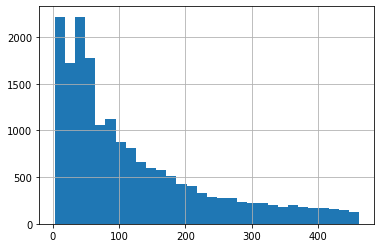

In [297]:
data.query('days_exposition > -1')['days_exposition'].hist(bins=30)

Тенденция распределния соответствует пуассоновскому, но есть несколько максимумов. Изучим характериные величины, исключая пропуски.

In [298]:
data.query('days_exposition > -1')['days_exposition'].describe()

count    18358.000000
mean       121.774975
std        111.698541
min          3.000000
25%         40.000000
50%         82.000000
75%        175.000000
max        462.000000
Name: days_exposition, dtype: float64

Медианное значение составляет 72 дня, среднее - 100 дней, стандартное отклонение - 84 дня, диапазон величин - от 3 до 339 дней.

Завышенное относительно медианы среднее обусловлено небольшим количеством значений, сильно превышающих остальные. Поэтому за типичное время, которое занимает продажа квартиры, лучше принять медиану - 72 дня.

За быстрые и медленные продажи можно принять те, которые выходят за границы полуторного межквартильного размаха. Построим диаграмму размаха методом `boxplot()`.

<AxesSubplot:>

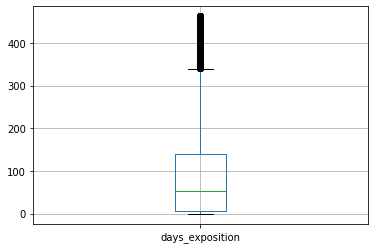

In [299]:
data.boxplot(column='days_exposition')

Найдем верхнюю границу.

In [300]:
print((data['days_exposition'].describe()['75%'] - data['days_exposition'].describe()['25%'])
     * 1.5 + data['days_exposition'].describe()['75%'])

339.5


Долгими можно считать продажи, на которые потребовалось больше 284 дней.

Нижняя граница здесь является минимальным значением в столбце `'days_exposition'`. Поэтому за быстрые продажи примем те, время ожидания которых меньше первого квартиля - 36 дней.

#### Зависимость стоимости квартиры от других факторов

##### От общей площади

Найдем коэффициент корреляции Пирсона между ценой квартиры и ее площадью методом `corr()`.

In [301]:
data['last_price'].corr(data['total_area'])

0.7328854186694573

Есть высокая линейная связь. Изучим диаграмму рассеяния `hexbin`.

<AxesSubplot:xlabel='total_area', ylabel='last_price'>

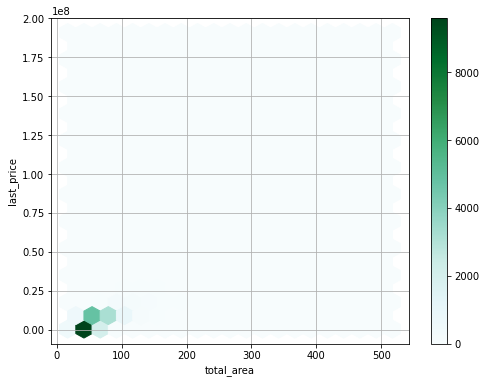

In [302]:
data.plot(x='total_area',y='last_price',kind='hexbin',figsize=(8,6),gridsize=20,
          sharex=False,grid=True)

Из-за большого диапазона цены и площади необходимо построить более детальный график. Выделим группу статистически важных данных - тех квартир, стоимость которых находится внутри полуторного межквартильного размаха. Это значение запишем в переменную `price_upper_bound`.

In [303]:
price_upper_bound = ((data['last_price'].describe()['75%'] - 
                      data['last_price'].describe()['25%']) * 1.5 + 
                     data['last_price'].describe()['75%'])

print(price_upper_bound)

11840275.0


Построим диаграмму рассеяния `hexbin` для квартир с ценой меньше `price_upper_bound`.<a id='4.3.1'></a>

<AxesSubplot:xlabel='total_area', ylabel='last_price'>

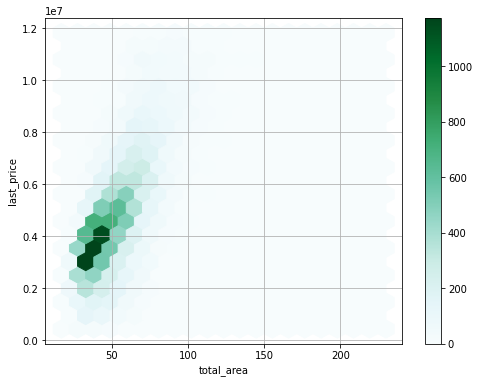

In [304]:
data.query('last_price < @price_upper_bound').plot(x='total_area',y='last_price',kind='hexbin',
                                         figsize=(8,6),gridsize=20,sharex=False,grid=True)

Здесь зависимость заметнее - с ростом площади увеличивается стоимость.

##### От жилой площади

Найдем коэффициент корреляции Пирсона между ценой квартиры и ее жилой площадью методом `corr()`.

In [305]:
data['last_price'].corr(data['living_area'])

0.6568960697724138

Есть заметная линейная связь. Аналогично [прыдущему пункту](#4.3.1) будем строить диаграммы `hexbin` для статистически важной группы квартир.

<AxesSubplot:xlabel='living_area', ylabel='last_price'>

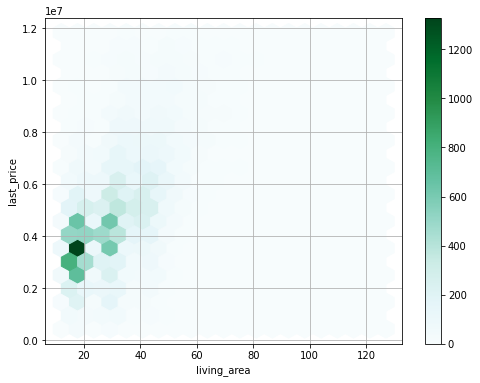

In [306]:
data.query('last_price < @price_upper_bound').plot(x='living_area',y='last_price',
                                                   kind='hexbin',figsize=(8,6),
                                                   gridsize=20,sharex=False,grid=True)

Возможно, линейная связь между жилой площадью и стоимостью квартиры обусловлена зависимостью жилой площади от общей площади. Найдем коэффициент корреляции для жилой площади и общей площади квартиры.

In [307]:
data['total_area'].corr(data['living_area'])

0.9379700674806521

Коэффициент корреляции очень близок к 1, следовательно, есть весьма высокая линейная связь жилой площади от общей площади квартиры, которая сильнее влияет на стоимость квартиры. Поэтому связь стоимости квартиры и жилой площади обусловлена третьим фактором - общей площадью квартиры.

##### От площади кухни

Найдем коэффициент корреляции Пирсона между ценой квартиры и площадью кухни методом `corr()`.

In [308]:
data['last_price'].corr(data['kitchen_area'])

0.5377685119182359

Есть заметная линейная зависимость. Изучим диаграмму рассеяния `hexbin` для группы статистически важных данных.

<AxesSubplot:xlabel='kitchen_area', ylabel='last_price'>

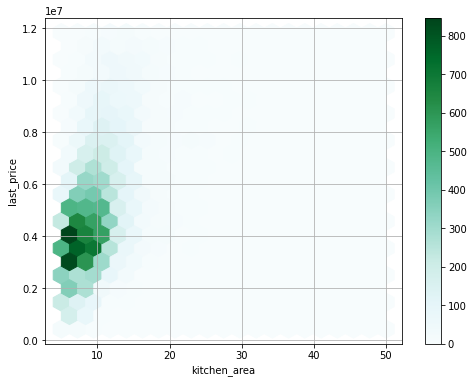

In [309]:
data.query('last_price < @price_upper_bound').plot(x='kitchen_area',y='last_price',kind='hexbin',
                                                   figsize=(8,6),gridsize=20,sharex=False,grid=True)

Оценим корреляцию между площадью кухни и общей площадью квартиры.

In [310]:
data['total_area'].corr(data['kitchen_area'])

0.5925588742850445

Коэффициент корреляции выше, есть заметная линейная связь. Поэтому связь стоимости квартиры и площади кухни обусловлена третьим фактором - общей площадью квартиры.

##### От количества комнат

Найдем коэффициент корреляции Пирсона между ценой квартиры и количеством комнат `corr()`.

In [311]:
data['last_price'].corr(data['rooms'])

0.43353844798338664

Есть умеренная линейная связь. Составим сводную таблицу для медианных цен квартир по количеству комнат методом `pivot_table()`, запишем полученную таблицу в переменную `pivot_table_rooms`.

In [312]:
pivot_table_rooms = data.pivot_table(index=['rooms'],values=['last_price'],aggfunc='median')

print(pivot_table_rooms)

       last_price
rooms            
0       2775000.0
1       3600000.0
2       4770169.0
3       6200000.0
4       9000000.0
5      14000000.0
6      18513500.0
7      24000000.0
8      23095000.0
9      23750000.0


Построим столбчатую диаграмму для сводной таблицы `pivot_table_rooms` методом `barplot()`.

<AxesSubplot:xlabel='rooms', ylabel='last_price'>

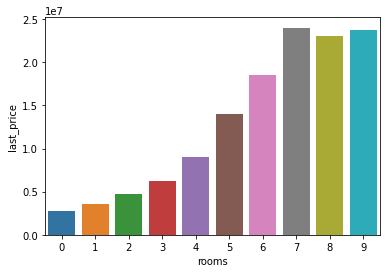

In [313]:
sb.barplot(data=pivot_table_rooms,x=pivot_table_rooms.index,y='last_price')

Стоимость квартиры зависит от количества комнат, однако это также может объясняться третьим фактором. Проверим связь количества комнат с общей площадью квартиры.

In [314]:
data['total_area'].corr(data['rooms'])

0.7634712799152695

Есть высокая линейная связь. Первоочередным фактором все-таки является общая площадь квартиры.

##### От типа этажа, на котором расположена квартира

Составим сводную таблицу для медианных цен квартир по типу этажа методом `pivot_table()`, запишем полученную таблицу в переменную `pivot_table_floor`.

In [315]:
pivot_table_floor = data.pivot_table(index=['floor_type'],values=['last_price'],aggfunc='median')

print(pivot_table_floor)

            last_price
floor_type            
другой       4850000.0
первый       3900000.0
последний    4350000.0


Построим столбчатую диаграмму для сводной таблицы `pivot_table_floor` методом `barplot()`.

<AxesSubplot:xlabel='floor_type', ylabel='last_price'>

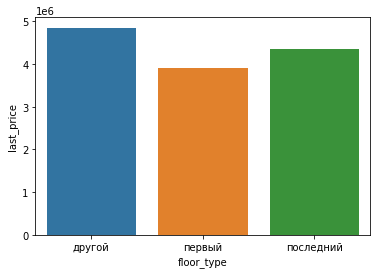

In [316]:
sb.barplot(data=pivot_table_floor,x=pivot_table_floor.index,y='last_price')

Наименьшая медианная стоимость у квартир на первом этаже, нибольшая у квартир из категории `'другой'`.

Явная связь между типом этажа и стоимостью квартиры не прослеживается. Возможно, это связано с тем, что категория `'другой'` включает в себя более широкий диапазон этажей, чем категории `'первый'` и `'последний'`. 

##### От даты размещения

Рассмотрим сначала зависимость стоимости от дня недели размещения объявления. Построим график для медианных значений столбца `'last_price'` по столбцу `'publication_weekday'`.

<AxesSubplot:xlabel='publication_weekday'>

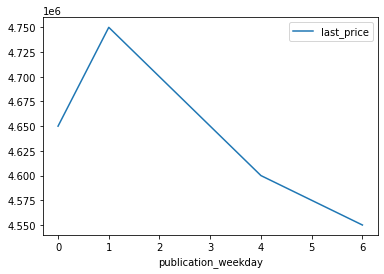

In [317]:
data.pivot_table(index=['publication_weekday'],values=['last_price'],aggfunc='median').plot(y='last_price')

Медианная стоимость квартиры ко вторнику возрастает до максимума, затем к воскресенью падает до минимума.

Построим график для медианных значений столбца `'last_price'` по столбцу `'publication_month'`.

<AxesSubplot:xlabel='publication_month'>

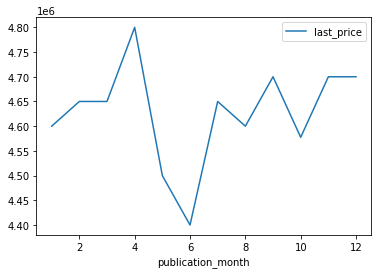

In [318]:
data.pivot_table(index=['publication_month'],values=['last_price'],aggfunc='median').plot(y='last_price')

Медианная стоимость квартиры нелинейно зависит от месяца публикации объявления. К апрелю стоимость квартир возрастает до максимума, а к июню падает до минимума.

Построим график для медианных значений столбца `'last_price'` по столбцу `'publication_year'`.

<AxesSubplot:xlabel='publication_year'>

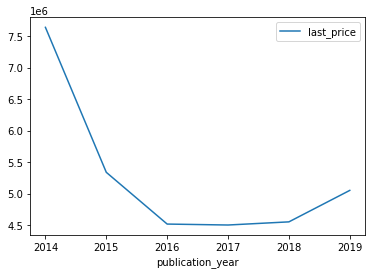

In [319]:
data.pivot_table(index=['publication_year'],values=['last_price'],aggfunc='median').plot(y='last_price')

Заметно сильное снижение стоимости квартир с 2014 до 2017 года, с 2017 года стоимость квартир начала возрастать.

Добавила недостающие графики, исправила зависимость стоимости от даты размещения объявления, построила линейные графики. 

#### Средняя цена одного квадратного метра в населенных пунктах

Посчитаем среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений. 

Создадим сводную таблицу для столбцов `'locality_name'` и `'price_per_meter'`, в параметр `aggfunc` передадим список функций, которые необходимо применить к значениям из столбца `'price_per_meter'`: `['count','mean','median']`. Методом `sort_values()` отсортируем населенные пункты по количеству объявлений по убыванию. Методом `head()` возвратим первые 10 строк таблицы. Полученную таблицу запишем в переменную `pivot_table_localities` и выведем на экран.

In [320]:
pivot_table_localities = data.pivot_table(index=['locality_name'],values=['price_per_meter'],
                                          aggfunc=['count','mean','median']).sort_values(
    by=('count', 'price_per_meter'),ascending=False).head(10)

print(pivot_table_localities)

                            count            mean          median
                  price_per_meter price_per_meter price_per_meter
locality_name                                                    
Санкт-Петербург             15663   114303.759972   104687.500000
посёлок Мурино                515    85563.326907    85657.142857
посёлок Шушары                440    78677.364217    76876.172608
Всеволожск                    398    68654.473986    65789.473684
Пушкин                        369   103125.819291   100000.000000
Колпино                       338    75424.579098    74723.748474
посёлок Парголово             324    90191.147389    91780.224134
Гатчина                       307    68746.146763    67796.610169
деревня Кудрово               287    92312.310411    91666.666667
Выборг                        237    58141.909153    58158.319871


Найдем населенный пункт с самой высокой средней стоимостью квадратного метра, выведем его индекс методом `idxmax()`.

In [321]:
pivot_table_localities[('mean', 'price_per_meter')].idxmax()

'Санкт-Петербург'

Найдем населенный пункт с самой низкой средней стоимостью квадратного метра, выведем его индекс методом `idxmin()`.

In [322]:
pivot_table_localities[('mean', 'price_per_meter')].idxmin()

'Выборг'

#### Расстояние от центра города в Санкт-Петербурге

Найдем среднюю цену каждого километра до центра в Санкт-Петербурге. Ее можно определить как разность между средней стоимостью квартир на соседних километрах.

Методом `query()` выделим срез строк, относящихся к Санкт-Петербургу, исключая строки с пропущенными расстояния до центра. Методом `pivot_table()` составим сводную таблицу по столбцу `'cityCenters_nearest_km'` для стоимости квартир, к которым применим функцию `'mean'`. Полученную таблицу запишем в переменную `data_cityCenters_nearest_km` и выведем на экран. 

In [323]:
data_cityCenters_nearest_km = data.query(
    'locality_name == "Санкт-Петербург" and cityCenters_nearest_km != -1').pivot_table(
    index=['cityCenters_nearest_km'],values=['last_price'],aggfunc='mean')

print(data_cityCenters_nearest_km.head())

                          last_price
cityCenters_nearest_km              
0                       2.368987e+07
1                       1.639053e+07
2                       1.490157e+07
3                       1.195989e+07
4                       1.327154e+07


Построим график зависимости средней стоимости квартир в Санкт-Петербурге от расстояния до центра.

<AxesSubplot:xlabel='cityCenters_nearest_km'>

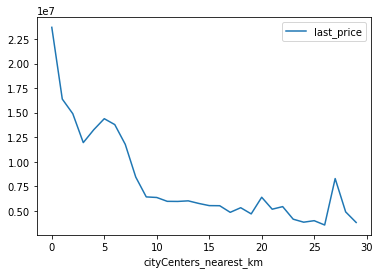

In [324]:
data_cityCenters_nearest_km.plot(y='last_price')

Заметна явная связь: с увеличением расстояния до центра стоимость квартир в Санкт-Петербурге падает.

Для вычисления стоимости каждого километра напишем функцию `price_per_km()`. В теле функции реализован цикл по индексам строк таблицы, в столбец `'price_per_km'` записывается разность средней стоимости в текущей строке и следующей. Функция возвращает таблицу с новым столбцом `'price_per_km'`. 

In [325]:
def price_per_km(data):

    for km in range(data.shape[0] - 1):

        data.loc[km,'price_per_km'] = data.loc[km,'last_price'] - data.loc[km + 1,'last_price']
    
    return data

Применим функцию `price_per_km()` к таблице `data_cityCenters_nearest_km` и выведем ее на экран.

In [326]:
data_cityCenters_nearest_km = price_per_km(data_cityCenters_nearest_km)

print(data_cityCenters_nearest_km)

                          last_price  price_per_km
cityCenters_nearest_km                            
0                       2.368987e+07  7.299338e+06
1                       1.639053e+07  1.488961e+06
2                       1.490157e+07  2.941683e+06
3                       1.195989e+07 -1.311645e+06
4                       1.327154e+07 -1.120908e+06
5                       1.439244e+07  5.986968e+05
6                       1.379375e+07  2.010893e+06
7                       1.178285e+07  3.330190e+06
8                       8.452664e+06  2.017300e+06
9                       6.435364e+06  5.927214e+04
10                      6.376092e+06  3.917679e+05
11                      5.984324e+06  1.038042e+04
12                      5.973943e+06 -5.933733e+04
13                      6.033281e+06  2.620449e+05
14                      5.771236e+06  2.224379e+05
15                      5.548798e+06  1.130413e+04
16                      5.537494e+06  6.719197e+05
17                      4.86557

Визуализируем полученные данные ввиде столбчатой диаграммы.

<AxesSubplot:xlabel='cityCenters_nearest_km', ylabel='price_per_km'>

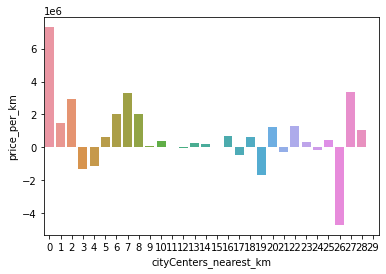

In [327]:
sb.barplot(data=data_cityCenters_nearest_km,x=data_cityCenters_nearest_km.index,y='price_per_km')

Исследуем зависимость стоимости квартир от расстояния до центра города. Найдем коэффициент корреляции Пирсона для столбцов `'last_price'` и `'cityCenters_nearest'`.

In [328]:
data['last_price'].corr(data['cityCenters_nearest'])

-0.2691966093624394

Между стоимостью квартиры и расстоянием до центра города почти нет линейной связи. 

Найдем коэффициент корреляции Пирсона для столбцов `'price_per_meter'` и `'cityCenters_nearest'`.

In [329]:
data['price_per_meter'].corr(data['cityCenters_nearest'])

-0.34636704608903945

Линейная зависимость между стоимостью одного кв. м и расстоянием до центра города сильнее, но все равно слабо выражена. С увеличением расстояния стоимость падает.

Найдем коэффициент корреляции Пирсона для стоимости квартиры в Санкт-Петербурге и расстояния до центра города. Для этого запишем индексы таблицы `data_cityCenters_nearest_km` в новый столбец `'km'` и применим метод `'corr()'`.

In [330]:
data_cityCenters_nearest_km['km'] = data_cityCenters_nearest_km.index

data_cityCenters_nearest_km['km'].corr(data_cityCenters_nearest_km['last_price'])

-0.8014080884141273

Коэффициент корреляции близок к единице, в Санкт-Петербурге прослеживается сильная связь между стоимостью квартиры и расстоянием до центра города - чем дальше квартира от центра, тем она дешевле.

### Общий вывод

Было проведено исследование о том, что влияет на конечную стоимость квартиры на рынке недвижимости. Входные данные — архив объявлений за несколько лет о продаже квартир в Санкт-Петербурге и соседних населённых пунктах.

Результаты исследования будут учтены при построении автоматизированной системы, отслеживающей аномалии и мошеннические действия.

1. Были изучены следующие параметры объектов:

    1.1 Общая площадь
    
    Медианное значение составляет 52 кв. м, среднее - 60 кв. м. Площадь квартир имеет большой разброс по величине (от 17 кв. м до 517 кв. м) относительно самих значений. Гистограмма соответствует распределению Пуассона, но с очень длинным хвостом. Пик на гистограмме соответствует медианному значению.
    
    1.2 Жилая площадь
    
    Медианное значение составляет 30 кв. м, среднее - 34,5 кв. м, стандартное отклонение - 21 кв. м, диапазон величин - от 12 кв. м до 347,5 кв. м. Ситуация аналогична распределению общей площади квартир. Распределение также соответствует распределению Пуассона.
    
    1.3 Площадь кухни
    
    Медианное значение составляет 9,2 кв. м, среднее - 10,5 кв. м, стандартное отклонение - 5,4 кв. м, диапазон величин - от 5 кв. м до 58,4 кв. м. Ситуация также аналогична распределению общей площади квартир, распределение соответствует распределению Пуассона.
    
    1.4 Цена объекта
    
    Медианное значение составляет 4,65 млн. руб, среднее - 6,39 млн. руб, стандартное отклонение - 7,8 млн. руб, диапазон величин - от 0,43 млн. руб до 191 млн. руб. Минимальное и максимальное значения отличаются почти на 3 порядка. Ситуация аналогична распределению общей площади квартир. Распределение также соответствует распределению Пуассона с длинным хвостом.
    
    1.5 Количество комнат
    
    Медианное и среднее количество комнат близки по величине - 2 комнаты, стандартное отклонение - 1, диапазон величин - от 0 (студии) до 9. Ситуация аналогична распределению общей площади квартир, распределение также соответствует распределению Пуассона.
    
    1.6 Высота потолков
    
    Медианное значение составляет 2,65 м, среднее - 2,73 м, стандартное отклонение - 0,27 м, диапазон величин - от 2,5 м до 4,9 м. Стандартное отклонение относительно невелико, разброс величин небольшой. Распределение соответствует распределению Пуассона с пиком в области медианного значения.
    
    1.7 Этаж квартиры
    
    Медианное значение - 4 этаж, среднее - 6, стандартное отклонение - 5, диапазон величин - от 1 до 33. Минимальное и максимальное значения отличаются более, чем на порядок. Здесь стандартное отклонение немного превышает медианное значение. Наиболее часто встречающийся этаж (мода) - 2. Распределение соответствует распределению Пуассона.
    
    1.8 Тип этажа квартиры («первый», «последний», «другой»)
   
    Наиболее часто встречающийся тип этажа - `'другой'`, из 23 560 объявлений сюда относится 17 262. Последний этаж встречается немного чаще первого.
    
    1.9 Общее количество этажей в доме
    
    Медианное значение - 9 этаж, среднее - 11, стандартное отклонение - 7, диапазон величин - от 1 до 37. Распределение не соответствует пуассоновскому. На графике два наибольших пика соответствуют 5 и 9 этажам. Такое неоднородное распределение может быть связано с особенносями типовых домов в Санкт-Петербурге и области.
    
    1.10 Расстояние до центра города в метрах
    
    Медианное значение составляет 13 км, среднее - 14 км, стандартное отклонение - 8,6 км, диапазон величин - от 0 до 65 км. Стандартное отклонение немного меньше медианного значения. Распределение не соответствует пуассоновскому. Это связано с тем, что в таблице присутствует несколько населенных пунктов. Ниже приведена гистограмма распределения расстояния до центра города в метрах для всех квартир, а также два распределения: для квартир в Санкт-Петербурге и в остальных населенных пунктах.
    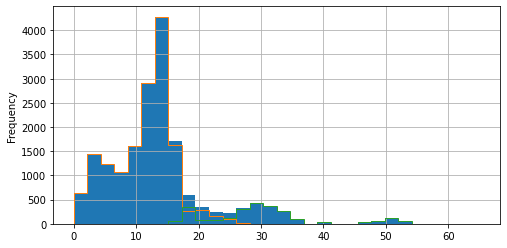
    На общей гистограмме пики в районе 5 км и 15 км обеспечиваются квартирами в Санкт-Петербурге, а небольшие пики в области 30, 40 и 50 км обусловлены другими населенными пунктами.
    
    1.11 Расстояние до ближайшего аэропорта
    
    Медианное значение составляет 27 км, среднее - 29 км, стандартное отклонение - 12,6 км, диапазон величин - от 0 до 85 км. В целом, тенденция распределения соответствует пуассоновскому. Побочные пики также могут быть связаны с наличием населенных пунктов.
    
    1.12 Расстояние до ближайшего парка
    
    Медианное значение составляет 454 м, среднее - 491 м, стандартное отклонение - 343 м, диапазон величин - от 1 до 3190 м. Распределение соответствует пуассоновскому, максимум находится в области медианного и среднего значений.
    
    1.13 День и месяц публикации объявления
       
    Для дней публикации объявлений медианное значение - четверг, среднее - четверг, стандартное отклонение - 2 дня. В будни объявления о продаже квартир публикуют чаще, чем на выходных, причем ближе к выходным частота возрастает. Чаще всего объявления публикуют по четвергам.
    
    Для месяцев публикации объявлений медианное значение - июнь, среднее - июнь, стандартное отклонение - 3,5 месяца. Реже всего объявления публикуют в декабре, январе и мае. Это может быть связано с выходными и праздничными днями. Чаще всего объявления публикуют в феврале, марте и апреле, за этот период частота немного падает. А в период с июля по ноябрь количество объевлений возрастает.
    

2. Было проанализировано, как быстро продавались квартиры (столбец `'days_exposition'`). Этот параметр показывает, сколько дней было размещено каждое объявление.

    Тенденция распределния соответствует пуассоновскому, но есть несколько максимумов.

    Медианное значение составляет 72 дня, среднее - 100 дней, стандартное отклонение - 84 дня, диапазон величин - от 3 до 339 дней.

    Завышенное относительно медианы среднее обусловлено небольшим количеством значений, сильно превышающих остальные. Поэтому за типичное время, которое занимает продажа квартиры, лучше принять медиану - 72 дня.

    За медленные продажи можно принять те, которые выходят за границу полуторного межквартильного интервала, то есть которые больше 284 дня.

    Нижняя граница на диаграмме размаха является минимальным значением в столбце `'days_exposition'`. Поэтому за быстрые продажи примем те, время ожидания которых меньше первого квартиля - 36 дней.

3. Было изучено, какие факторы больше всего влияют на общую (полную) стоимость объекта. Были проверены гипотезы о том, что на конечную стоимость объекта влияют:
    
    3.1 Общая площадь    

    Коэффициент корреляции Пирсона между общей стоимостью квартиры и общей площадью равен 0.73. Есть высокая линейная связь.
    
    Гипотеза подтвердилась.
    
    Рекомендация: общую площадь можно использовать для выявления аномалий. 
    
    3.2 Жилая площадь
       
    Коэффициент корреляции Пирсона между ценой квартиры и ее жилой площадью равен 0.66. Есть заметная линейная связь.
    
    Линейная связь между жилой площадью и стоимостью квартиры обусловлена третьим фактором - общей площадью квартиры. Коэффициент корреляции для жилой площади и общей площади квартиры очень близок к 1. Более важным фактором является общая площадь квартиры, так как корреляция между ней и стоимостью квартиры сильнее.
    
    Гипотеза частично подтвердилась.
    
    Рекомендация: жилую площадь можно использовать как дополнительный фактор для выявления аномалий. 
    
    3.3 Площадь кухни
       
    Коэффициент корреляции Пирсона между ценой квартиры и площадью кухни равен 0.54 - есть заметная линейная зависимость.

    Корреляция между площадью кухни и общей площадью квартиры равна 0.59, следовательно, есть заметная линейная связь. Поэтому связь стоимости квартиры и площади кухни обусловлена третьим фактором - общей площадью квартиры.
    
    Гипотеза частично подтвердилась.
    
    Рекомендация: площадь кухни можно использовать как дополнительный фактор для выявления аномалий. 
    
    3.4 Количество комнат
    
    Коэффициент корреляции Пирсона между ценой квартиры и количеством комнат равен 0.43. Есть умеренная линейная связь. Стоимость квартиры зависит от количества комнат, однако это также объясняется третьим фактором. Коэффициент корреляции между количеством комнат и общей площадью квартиры достаточно высок - 0.76, есть высокая линейная связь. Первоочередным фактором все-таки является общая площадь квартиры.
    
    Гипотеза частично подтвердилась.
    
    Рекомендация: количество комнат можно использовать как дополнительный фактор для выявления аномалий. 
    
    3.5 Этаж, на котором расположена квартира (первый, последний, другой)
    
    Наименьшая медианная стоимость у квартир на первом этаже, наибольшая у квартир на этаже из категории `'другой'`. Линейная связь между типом этажа и стоимостью квартиры не прослеживается. Возможно, это связано с тем, что категория `'другой'` включает в себя более широкий диапазон этажей, чем категории `'первый'` и `'последний'`. 
    
    Гипотеза частично подтвердилась.
    
    Рекомендация: тип этажа можно использовать как дополнительный фактор для выявления аномалий. 
    
    3.6 Дата размещения (день недели, месяц, год)
    
    Ниже показан график для медианных значений столбца стоимости квартиры по дням недели публикации объявления.

    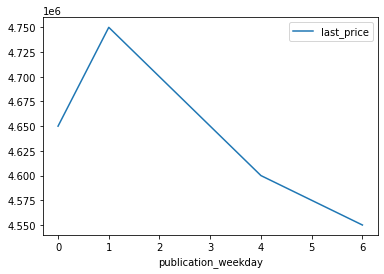

    Медианная стоимость квартиры ко вторнику возрастает до максимума, затем к воскресенью падает до минимума.

    Ниже показан график для медианных значений столбца стоимости квартиры по месяцам публикации объявления.

    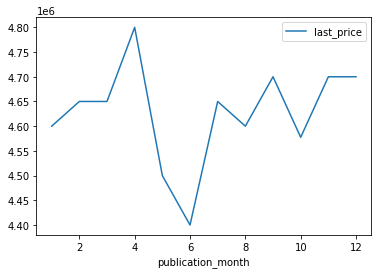

    Медианная стоимость квартиры нелинейно зависит от месяца публикации объявления. К апрелю стоимость квартир возрастает до максимума, а к июню падает до минимума.

    Ниже показан график для медианных значений столбца стоимости квартиры по годам публикации объявления.

    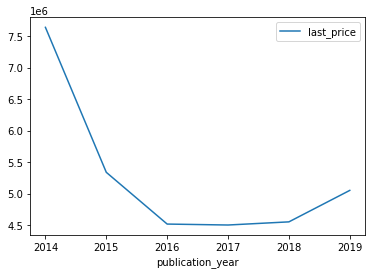

    Заметно сильное снижение стоимости квартир с 2014 до 2017 года, с 2017 года стоимость квартир начала возрастать.
   
    Гипотеза подтвердилась, однако предсказать поведение зависимости сложно.
    
    Рекомендация: тенденцию зависимости стоимости квартиры от даты размещения не стоит использовать для выявления аномалий, так как предсказать поведение зависимости сложно.


4. Была исследована средняя цена одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений. 

    Населенный пункт с самой высокой средней стоимостью квадратного метра - Санкт-Петербург, с самой низкой - Выборг.


5. Была исследована средняя цена каждого километра от центра в Санкт-Петербурге. А также проверена гипотеза о том, что стоимость объектов зависит от расстояния до центра города.

    Ниже показан график зависимости средней стоимости квартир в Санкт-Петербурге от расстояния до центра.

    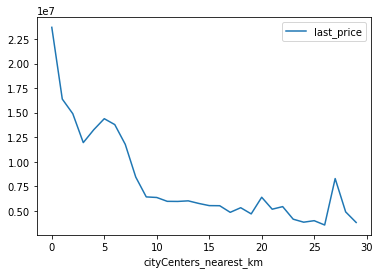

    Заметна явная связь: с увеличением расстояния до центра стоимость квартир в Санкт-Петербурге падает.

    Средняя цена каждого километра от центра в Санкт-Петербурге была определена как разность между средней стоимостью квартир на соседних километрах. Результаты представлены на столбчатой диаграмме ниже.
    
    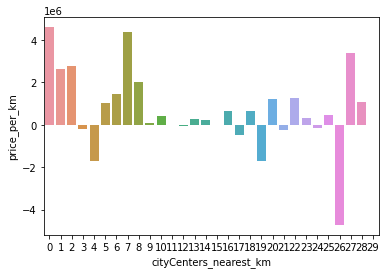

    Коэффициент корреляции Пирсона для стоимости квартиры и расстояния до центра города для всей выборки квартир равен -0.27. Между стоимостью квартиры и расстоянием до центра города есть слабая линейная связь. С увеличением расстояния стоимость падает.

    Коэффициент корреляции Пирсона для стоимости одного квадратного метра и расстояния до центра равен -0.35. Линейная зависимость между стоимостью одного кв. м и расстоянием до центра города сильнее, есть умеренная линейная связь. С увеличением расстояния стоимость падает.

    Коэффициент корреляции Пирсона между стоимостью квартиры в Санкт-Петербурге и расстоянием до центра города равен -0.80. В Санкт-Петербурге есть высокая линейная связь между стоимостью квартиры и расстоянием до центра города - чем дальше квартира от центра, тем она дешевле.
    
    Гипотеза подтвердилась.
    
    Рекомендация: расстояние до центра города можно учитывать при выявлении аномалий для квартир, находящихся в Санкт-Петербурге; для других населенных пунктов этот фактор можно использовать как вспомогательный.

Общие рекомендации:

Для построения автоматизированной системы, отслеживающей аномалии и мошеннические действия, можно использовать общую площадь квартиры, а для квартир в Санкт-Петербурге также можно использовать расстояние до центра города. 

В качестве дополнительных факторов можно использовать:
- жилую площадь квартиры;
- площадь кухни;
- количество комнат; 
- тип этажа;
- расстояние до центра города. 